# Cartpole

The state and control vectors $\textbf{x}$ and $\textbf{u}$ are defined as follows:

$$
\begin{equation*}
\textbf{x} = \begin{bmatrix}
    x & \dot{x} & \theta & \dot{\theta}
    \end{bmatrix}
\end{equation*}
$$

$$
\begin{equation*}
\textbf{u} = \begin{bmatrix}
    F_{x}
    \end{bmatrix}
\end{equation*}
$$

The goal is to swing the carptole upright:
$$
\begin{equation*}
\textbf{x}_{goal} = \begin{bmatrix}
    0 & 0 & 0 & 0
    \end{bmatrix}
\end{equation*}
$$

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function

In [3]:
import matplotlib.pyplot as plt

In [4]:
import torch
import numpy as np

In [5]:
import pddp
import pddp.examples

In [6]:
def plot(Z, U):
    t = np.arange(N + 1) * DT
    X = pddp.utils.encoding.decode_mean(Z, ENCODING).detach().numpy()
    U = U.detach().numpy()

    x = X[:, 0]
    x_dot = X[:, 1]
    theta = np.unwrap(X[:, 2])  # Makes for smoother plots.
    theta_dot = X[:, 3]
    
    plt.figure()
    plt.plot(theta, theta_dot)
    plt.xlabel("Orientation (rad)")
    plt.ylabel("Angular velocity (rad/s)")
    plt.title("Orientation Phase Plot")

    plt.figure()
    plt.plot(t, x)
    plt.xlabel("Time (s)")
    plt.ylabel("Position (m)")
    plt.title("Position path")
    
    plt.figure()
    plt.plot(t, x_dot)
    plt.xlabel("Time (s)")
    plt.ylabel("Velocity (m / s)")
    plt.title("Velocity path")
    
    plt.figure()
    plt.plot(t, theta)
    plt.xlabel("Time (s)")
    plt.ylabel("Orientation (rad)")
    plt.title("Orientation path")

    plt.figure()
    plt.plot(t, theta_dot)
    plt.xlabel("Time (s)")
    plt.ylabel("Angular velocity (rad / s)")
    plt.title("Angular velocity path")
    
    plt.figure()
    plt.plot(t[:-1], U)
    plt.xlabel("Time (s)")
    plt.ylabel("Force (N)")
    plt.title("Constrained action path")
    
    plt.figure()
    plt.plot(J_hist)
    plt.xlabel("Iteration")
    plt.ylabel("Total loss")
    plt.title("Loss path")

In [7]:
def prepare_plot():
    %matplotlib qt
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)
    plt.ion()
    plt.xlabel("Time steps")
    fig.show()
    fig.canvas.draw()
    return fig, ax


def plot_variance(fig, ax, Z, encoding, indices=None, std_scale=1.0):
    ax.clear()

    mean_ = pddp.utils.encoding.decode_mean(Z, encoding)
    std_ = pddp.utils.encoding.decode_std(Z, encoding)

    if indices is None:
        indices = list(range(mean_.shape[-1]))
    
    t = torch.arange(Z.shape[0]).detach().numpy()
    for index in indices:
        mean = mean_[:, index].detach().numpy()
        std = std_[:, index].detach().numpy()

        _ = ax.plot(t, mean, label="Mean estimate")

        for i in range(1, 4):
            j = std_scale * i
            _ = plt.gca().fill_between(
                t.flat, (mean - j * std).flat, (mean + j * std).flat,
                color="#dddddd", alpha=1.0/i, label="Confidence")

    fig.canvas.draw()

In [8]:
N = 25  # Horizon length.
DT = 0.1  # Time step (s).
RENDER = True  # Whether to render the environment or not.
ENCODING = pddp.StateEncoding.STANDARD_DEVIATION_ONLY

In [9]:
cost = pddp.examples.cartpole.CartpoleCost()
env = pddp.examples.cartpole.CartpoleEnv(dt=DT, render=RENDER)
model_class = pddp.examples.cartpole.CartpoleDynamicsModel

In [10]:
model = pddp.models.bnn.bnn_dynamics_model_factory(
    env.state_size, env.action_size,
    [200, 200],
    model_class.angular_indices,
    model_class.non_angular_indices,
)(n_particles=100)

In [11]:
def on_iteration(iteration, state, Z, U, J_opt):
    J_opt = J_opt.detach().numpy()
    J_hist.append(J_opt)

    mean = pddp.utils.encoding.decode_mean(Z, encoding=ENCODING)
    var = pddp.utils.encoding.decode_var(Z, encoding=ENCODING).detach().numpy()
    final_state = mean[-1].detach().numpy()
    final_state[2] = (final_state[2] + np.pi) % (2 * np.pi) - np.pi

    print("iteration", iteration + 1, state, J_opt, final_state, var.max())

In [12]:
controller = pddp.controllers.PDDPController(env, model, cost,
                                             training_opts={"n_iter": 1000},
                                             model_opts={"sample_input_distribution": True})

In [13]:
U = torch.randn(N, model.action_size)

In [14]:
J_hist = []
controller.train()
Z, U, state = controller.fit(U, encoding=ENCODING, n_iterations=20, max_var=0.4,
                             on_iteration=on_iteration, max_J=70)

iteration 1 accepted 2104.8564 [ 2.7674892   2.1131773  -0.04419834 -2.2543905 ] 9.163061
iteration 2 accepted 959.5536 [ 2.296408   -0.22125876 -0.9900177  -0.91422194] 3.5584326
iteration 3 accepted 560.45575 [ 1.6560931  -0.5433492  -0.52639467 -0.45438382] 3.0583904
iteration 4 accepted 514.0641 [ 1.5534147  -0.53220856 -0.5603736  -0.252751  ] 3.0522847
iteration 5 accepted 504.08072 [ 1.6193231   0.22350465 -0.5674928   0.13684651] 3.1394765
iteration 6 accepted 505.0008 [ 1.6307719   0.25461823 -0.5554865   0.17495431] 3.06493
iteration 7 accepted 507.9231 [ 1.6314336   0.2757089  -0.55129176  0.19600864] 3.0330398
iteration 8 accepted 511.94 [ 1.6247512   0.3411264  -0.5340951   0.23649889] 3.0590212
iteration 9 accepted 509.52734 [ 1.6364181   0.33230066 -0.53016645  0.25630015] 3.0596256
iteration 10 accepted 515.34045 [ 1.6400867   0.35223663 -0.5032857   0.26119262] 3.1320648
iteration 11 FAILED   511.38303 [ 1.6292152   0.33894044 -0.53566676  0.2717645 ] 3.147877
iteratio

iteration 1 accepted 13189.317 [ 8.069103  -6.0484147 -2.622139  -4.0998716] 3.5669513
iteration 2 accepted 2819.9463 [ 4.0981684   0.92994183 -1.9461793   1.6911325 ] 5.1397524
iteration 3 accepted 2753.557 [ 3.854087    0.72394234 -2.0133936   2.0913672 ] 5.157324
iteration 4 accepted 2716.1965 [ 3.9558444   0.80516714 -1.9529828   1.7882895 ] 5.253344
iteration 5 accepted 2679.56 [ 3.8851793  0.7365356 -1.9535416  1.884519 ] 5.017929
iteration 6 accepted 2616.6257 [4.2298064  0.56156576 2.9594636  0.68999004] 3.1435583
iteration 7 accepted 1084.3337 [ 2.0382664  -0.06256354 -2.9203317  -1.0880057 ] 1.1973225
iteration 8 accepted 1020.71173 [ 2.0322003   0.5684941  -2.8995337  -0.66037536] 1.1001655
iteration 9 accepted 803.38324 [1.1719024 0.2924524 2.811326  1.1614339] 1.0708141
iteration 10 FAILED   763.92065 [1.182318   0.30850303 2.678202   1.0324749 ] 1.0448163
iteration 11 accepted 833.2225 [1.2798518  0.41960752 2.6890345  1.1671462 ] 1.0810049
iteration 12 FAILED   797.31396

iteration 1 FAILED   5599.257 [-0.47613898  0.35355657  1.8637303  -7.176795  ] 1.0402462
iteration 2 accepted 6190.745 [ 1.7414701 -3.2740827  2.5868287 -6.4679976] 6.4075475
iteration 3 accepted 4169.325 [ 1.8937584 -4.291214  -3.08496   -3.5640326] 5.1379366
iteration 4 accepted 3189.963 [ 4.302003  -1.636449  -1.4909385 -2.2428067] 7.757381
iteration 5 accepted 2193.963 [ 4.1503754  -0.47146994 -0.8922699  -0.3058107 ] 7.2677956
iteration 6 accepted 1845.0721 [ 3.1863177   0.15421748 -0.18365079  2.4601364 ] 2.5580268
iteration 7 accepted 631.37665 [ 1.8638842   0.3431934  -0.6445158   0.04468566] 1.1720736
iteration 8 accepted 556.3761 [ 1.6932412  0.7708764 -0.6725686  0.6137964] 1.3892004
iteration 9 accepted 509.36816 [ 1.6954486   0.6622082  -0.79401094 -0.02929175] 1.3628578
iteration 10 accepted 483.5196 [ 1.6518817   0.5831081  -0.7907279   0.07227302] 1.4547585
iteration 11 FAILED   677.7673 [ 1.751369    0.89791286 -0.5699447   1.1632748 ] 1.4001118
iteration 12 accepted 

iteration 1 accepted 2033.6346 [ 1.8199825  1.1551976 -2.138199  -3.3104088] 3.22233
iteration 2 accepted 2119.7346 [ 1.7244958  -0.28819656  1.1747766   3.6390114 ] 6.520912
iteration 3 accepted 1385.4216 [ 1.5930711  -0.86642575  0.6845974   2.6025653 ] 6.210913
iteration 4 accepted 946.46985 [ 1.4193926 -1.2799842  0.3936463  1.5792089] 4.8052735
iteration 5 accepted 583.42017 [ 0.83728874  0.93204004  0.05777775 -1.7655662 ] 1.5772747
iteration 6 accepted 303.7895 [ 0.3343376  -0.17119575  0.84411544  0.7605084 ] 1.6668423
iteration 7 accepted 336.3336 [0.40476185 0.54968095 0.7445073  1.1858912 ] 1.3213999
iteration 8 accepted 188.3068 [ 0.38615495  0.7554809   0.5155744  -0.18210042] 0.74531794
iteration 9 accepted 169.90326 [0.16828087 0.02725291 0.81803274 0.337411  ] 0.54983014
iteration 10 accepted 150.77957 [ 0.13656549 -0.17330247  0.69917786 -0.23236799] 0.52744305
iteration 11 accepted 230.28986 [0.24371251 0.02487754 0.7572288  0.8761683 ] 1.3344375
iteration 12 accepted

iteration 1 accepted 4452.0767 [2.483075   0.59698963 2.0192466  5.431756  ] 16.552591
iteration 2 accepted 2002.876 [ 0.56886786 -3.4619899  -1.803275    0.8007593 ] 14.701954
iteration 3 accepted 1648.293 [ 0.6475635  -3.060876   -1.4661392   0.39522195] 15.196207
iteration 4 accepted 1531.5079 [ 1.6766622 -1.3341361 -2.797986  -2.040875 ] 7.3569145
iteration 5 accepted 839.97 [ 0.8405608  -0.9524332  -2.393386   -0.41883016] 17.644545
iteration 6 accepted 851.4787 [ 1.3866371   0.7141519  -0.53267556 -1.8501128 ] 11.623665
iteration 7 accepted 1277.8374 [ 1.2690626   0.41119558 -1.0118998  -2.7728772 ] 11.425899
iteration 8 accepted 696.1807 [1.4978597  1.1751873  0.2537858  0.88071424] 10.761888
iteration 9 FAILED   562.33685 [ 1.4395703   1.0160347  -0.01569063 -0.13275003] 11.963612
iteration 10 accepted 1205.1324 [ 1.467991   2.4228485 -0.6985453 -1.455497 ] 8.158524
iteration 11 accepted 440.68784 [1.148803   0.49873343 0.08667629 1.3701004 ] 5.103106
iteration 12 accepted 587.

iteration 1 accepted 243.95097 [ 0.30799574 -0.0050864   0.46517554  1.140362  ] 1.3647767
iteration 2 accepted 76.86885 [0.13961887 0.1073748  0.25810587 0.01625872] 0.69687724
iteration 3 accepted 85.38551 [ 0.076612    0.05938728  0.20876136 -0.26717854] 0.7092084
iteration 4 accepted 113.2826 [-0.0124849   0.01442775  0.10201654 -0.6425787 ] 0.6012914
iteration 5 FAILED   137.21571 [-0.0132682   0.02556562  0.06281614 -0.7969754 ] 0.718673
iteration 6 accepted 134.21005 [ 0.02025288  0.03633413  0.07074762 -0.7804457 ] 0.6520521
iteration 7 FAILED   87.04097 [ 0.09137815  0.09566754  0.20706558 -0.3226998 ] 0.6299925
iteration 8 FAILED   112.035095 [-0.06054987 -0.00160143  0.0982462  -0.6387888 ] 0.6448606
iteration 9 accepted 166.94916 [ 0.01799332  0.05631806  0.01120025 -0.96621346] 0.7347917
iteration 10 accepted 163.9141 [ 0.06899698  0.09312491  0.03956194 -0.9225055 ] 0.71838015
iteration 11 accepted 298.9457 [ 0.20509909  1.1430851   0.00302079 -0.8712257 ] 0.9946482
itera

iteration 1 accepted 208.92558 [-0.01285226  0.95277864  0.7111096   0.1163083 ] 0.8081547
iteration 2 accepted 161.86436 [-0.02271469  0.7856075   0.61132985  0.20366198] 0.5724969
iteration 3 accepted 105.44707 [-0.22330938  0.23562449  0.5308787   0.13991714] 1.0791161
iteration 4 accepted 107.87074 [-0.00422991 -0.00145638  0.51237106 -0.02099931] 2.3529377
iteration 5 accepted 159.03876 [ 0.12645192  0.6429033   0.21829526 -0.64693916] 0.7073105
iteration 6 accepted 143.2688 [ 0.25469664  0.72695225  0.36573154 -0.04040515] 0.6600183
iteration 7 accepted 133.23807 [ 0.24384254  0.6515595   0.33032215 -0.19576383] 0.6574542
iteration 8 FAILED   145.14204 [0.28135318 0.7057154  0.40533572 0.08646405] 0.67207336
iteration 9 accepted 163.88063 [0.33102134 0.7155153  0.46590585 0.33177364] 0.64932984
iteration 10 accepted 211.84766 [0.39546496 0.7702796  0.5491084  0.6190057 ] 0.68459237
iteration 11 FAILED   179.54884 [0.30559742 0.7080474  0.49873346 0.52310836] 0.66117823
iteration 

iteration 1 accepted 614.97614 [0.24475065 1.0508871  1.1899937  1.4354055 ] 4.0180044
iteration 2 accepted 317.36697 [ 0.2534153   0.85638356  0.8431851  -0.30512232] 3.8019087
iteration 3 accepted 330.62286 [ 0.22128284  0.7460203   0.64814895 -0.7903953 ] 3.7911015
iteration 4 accepted 340.77466 [ 0.19295813  0.731696    0.7264005  -0.87687683] 3.7106457
iteration 5 FAILED   313.53613 [ 0.21621588  0.6858243   0.6927287  -0.7774786 ] 3.5267978
iteration 6 accepted 441.06183 [ 0.22867285  0.7137158   0.5587208  -1.387928  ] 3.7162664
iteration 7 FAILED   308.20667 [ 0.271741    0.7942041   0.6977709  -0.54894406] 3.7699063
iteration 8 accepted 380.28192 [ 0.19819608  0.65139234  0.54673713 -1.1879425 ] 3.7350605
iteration 9 accepted 417.1902 [ 0.2114744  0.6321008  0.5787351 -1.3578777] 3.6144388
iteration 10 accepted 458.198 [ 0.20399319  0.61739516  0.49835736 -1.4966924 ] 3.4497128
iteration 11 FAILED   477.6726 [ 0.24703546  0.6875154   0.5966624  -1.4749067 ] 3.225247
iteration 

iteration 1 accepted 230.31671 [ 0.4770761   0.377949    0.31945592 -0.94907004] 0.5419803
iteration 2 accepted 204.51956 [-0.16595618  0.22800152  0.9579955   0.6911764 ] 0.5126813
iteration 3 accepted 132.40048 [0.0260458  0.22812176 0.7344868  0.3700661 ] 0.33743528
iteration 4 accepted 103.06247 [0.0811518  0.10687236 0.46666282 0.3137954 ] 0.9205457
iteration 5 accepted 117.57391 [ 0.05084813  0.09591444  0.16798241 -0.63089406] 1.0270097
iteration 6 FAILED   86.51422 [0.1003062  0.13477135 0.34535274 0.01234084] 0.89750564
iteration 7 accepted 88.55886 [ 0.08452529  0.09685338  0.275178   -0.2730726 ] 0.9083255
iteration 8 accepted 85.22389 [0.07538478 0.12640305 0.34877974 0.01680005] 0.98770237
iteration 9 accepted 88.620636 [0.1136719  0.12893629 0.3774448  0.11892688] 0.9113479
iteration 10 FAILED   88.974 [0.07464078 0.13673247 0.37999848 0.11984968] 0.95750237
iteration 11 accepted 87.17163 [ 0.06722888  0.06782149  0.27632976 -0.2680968 ] 0.9119577
iteration 12 FAILED   86

iteration 1 FAILED   160.3194 [-0.29993284  0.30974504  0.41548282 -0.83658814] 0.39573535
iteration 2 FAILED   118.328064 [-0.3114823   0.24938424  0.49547398 -0.49997813] 0.36271444
iteration 3 accepted 139.8621 [-0.2724443  0.3852836  0.4676084 -0.65151  ] 0.42799106
iteration 4 accepted 197.02391 [-0.26711023  0.42611194  0.3723094  -1.0136385 ] 0.39660385
iteration 5 FAILED   192.44612 [-0.22934088  0.4666735   0.38620347 -0.97482705] 0.40785167
iteration 6 FAILED   189.23767 [-0.2430516   0.44533372  0.39793485 -0.96505415] 0.40100873
iteration 7 accepted 236.55612 [-0.06669801  0.7602511   0.24437334 -1.102906  ] 0.19224794
iteration 8 accepted 85.43785 [-0.23873363  0.18409312  0.48081368  0.07957023] 0.3115189
iteration 9 accepted 87.56291 [-0.2927036   0.17171276  0.38830632 -0.24870157] 0.30300862
iteration 10 accepted 83.81625 [-0.2941666   0.16180396  0.4303329  -0.07702416] 0.32373497
iteration 11 accepted 81.76752 [-0.2881089   0.15584326  0.4363914   0.00287819] 0.31300

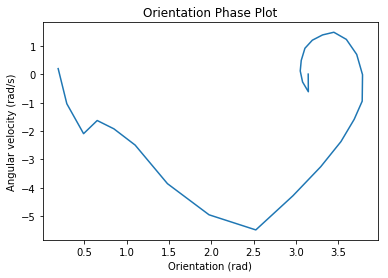

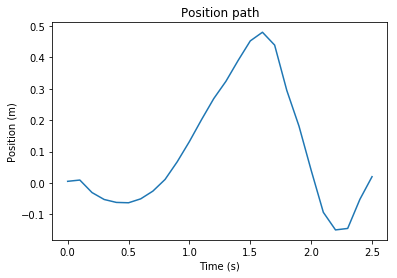

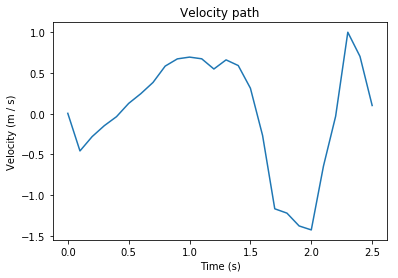

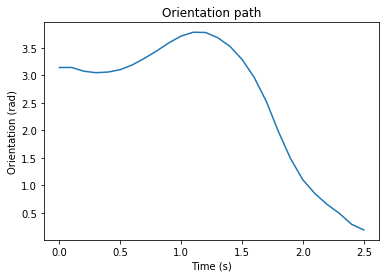

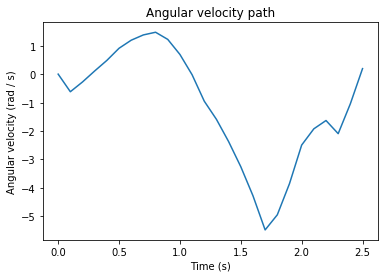

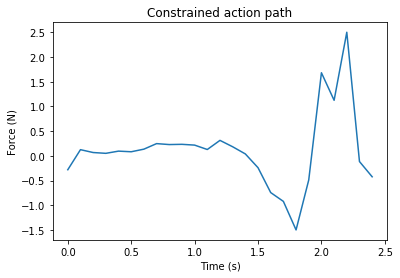

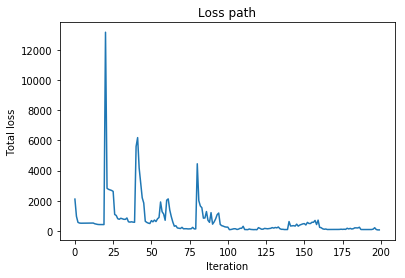

In [15]:
plot(Z, U)

In [16]:
if RENDER:
    # Wait for user interaction before visualizing. 
    _ = input("Press ENTER to continue")

Press ENTER to continue


In [17]:
import time

Z_ = torch.empty_like(Z)
Z_[0] = env.get_state().encode(ENCODING)
for i, u in enumerate(U):
    env.apply(u)
    Z_[i + 1] = env.get_state().encode(ENCODING)
    time.sleep(DT)

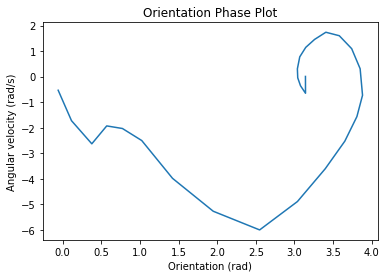

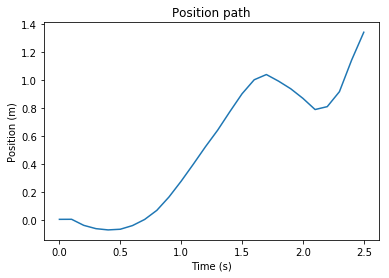

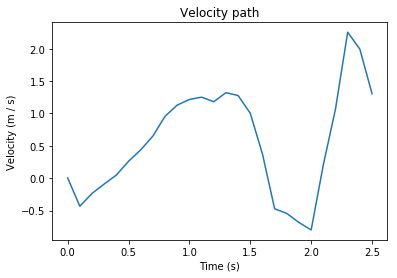

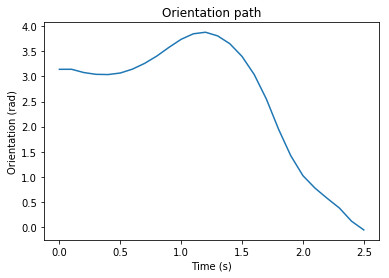

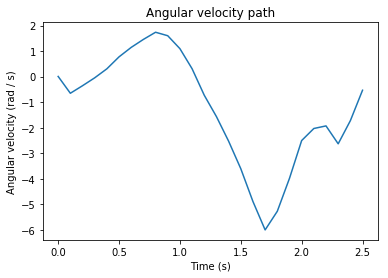

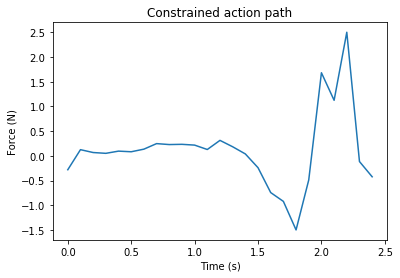

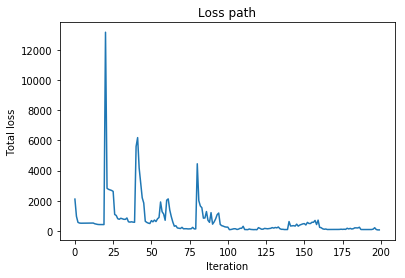

In [18]:
plot(Z_, U)

In [19]:
env.close()